In [ ]:
import os
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import collections
import statistics
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from PIL import Image
from wordcloud import ImageColorGenerator
import text2emotion as te
import time

In [2]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [3]:
stop_words = set(stopwords.words('english'))
stop_words.add("amp")
sid = SentimentIntensityAnalyzer()

In [4]:
year = ["April", "August", "December", "February", "January", "July", "June", "March", "November", "May", "October", "September"]
hashtags = ['Ukraine', 'Russia', 'Poland', 'Israel', 'Turkey']

April Ukraine
1131.7698974609375
April Russia
1097.48139834404
April Poland
1097.5443999767303
April Israel
672.8508722782135
April Turkey
623.8693163394928
August Ukraine
630.150821685791
August Russia
721.9154160022736
August Poland
661.5690772533417
August Israel
872.017885684967
August Turkey
877.3868205547333
December Ukraine
868.0188980102539
December Russia
835.877837896347
December Poland
591.7781403064728
December Israel
730.7289822101593
December Turkey
655.9991052150726
February Ukraine
589.1905643939972
February Russia
589.0904128551483
February Poland
575.1243436336517
February Israel
580.6608211994171
February Turkey
594.1424152851105
January Ukraine
658.7740323543549
January Russia
681.0600216388702
January Poland
543.5328946113586
January Israel
645.9404757022858
January Turkey
680.6151072978973
July Ukraine
942.9261517524719
July Russia
993.1827018260956
July Poland
604.6939535140991
July Israel
683.2767632007599
July Turkey
667.48561668396
June Ukraine
649.87427592277

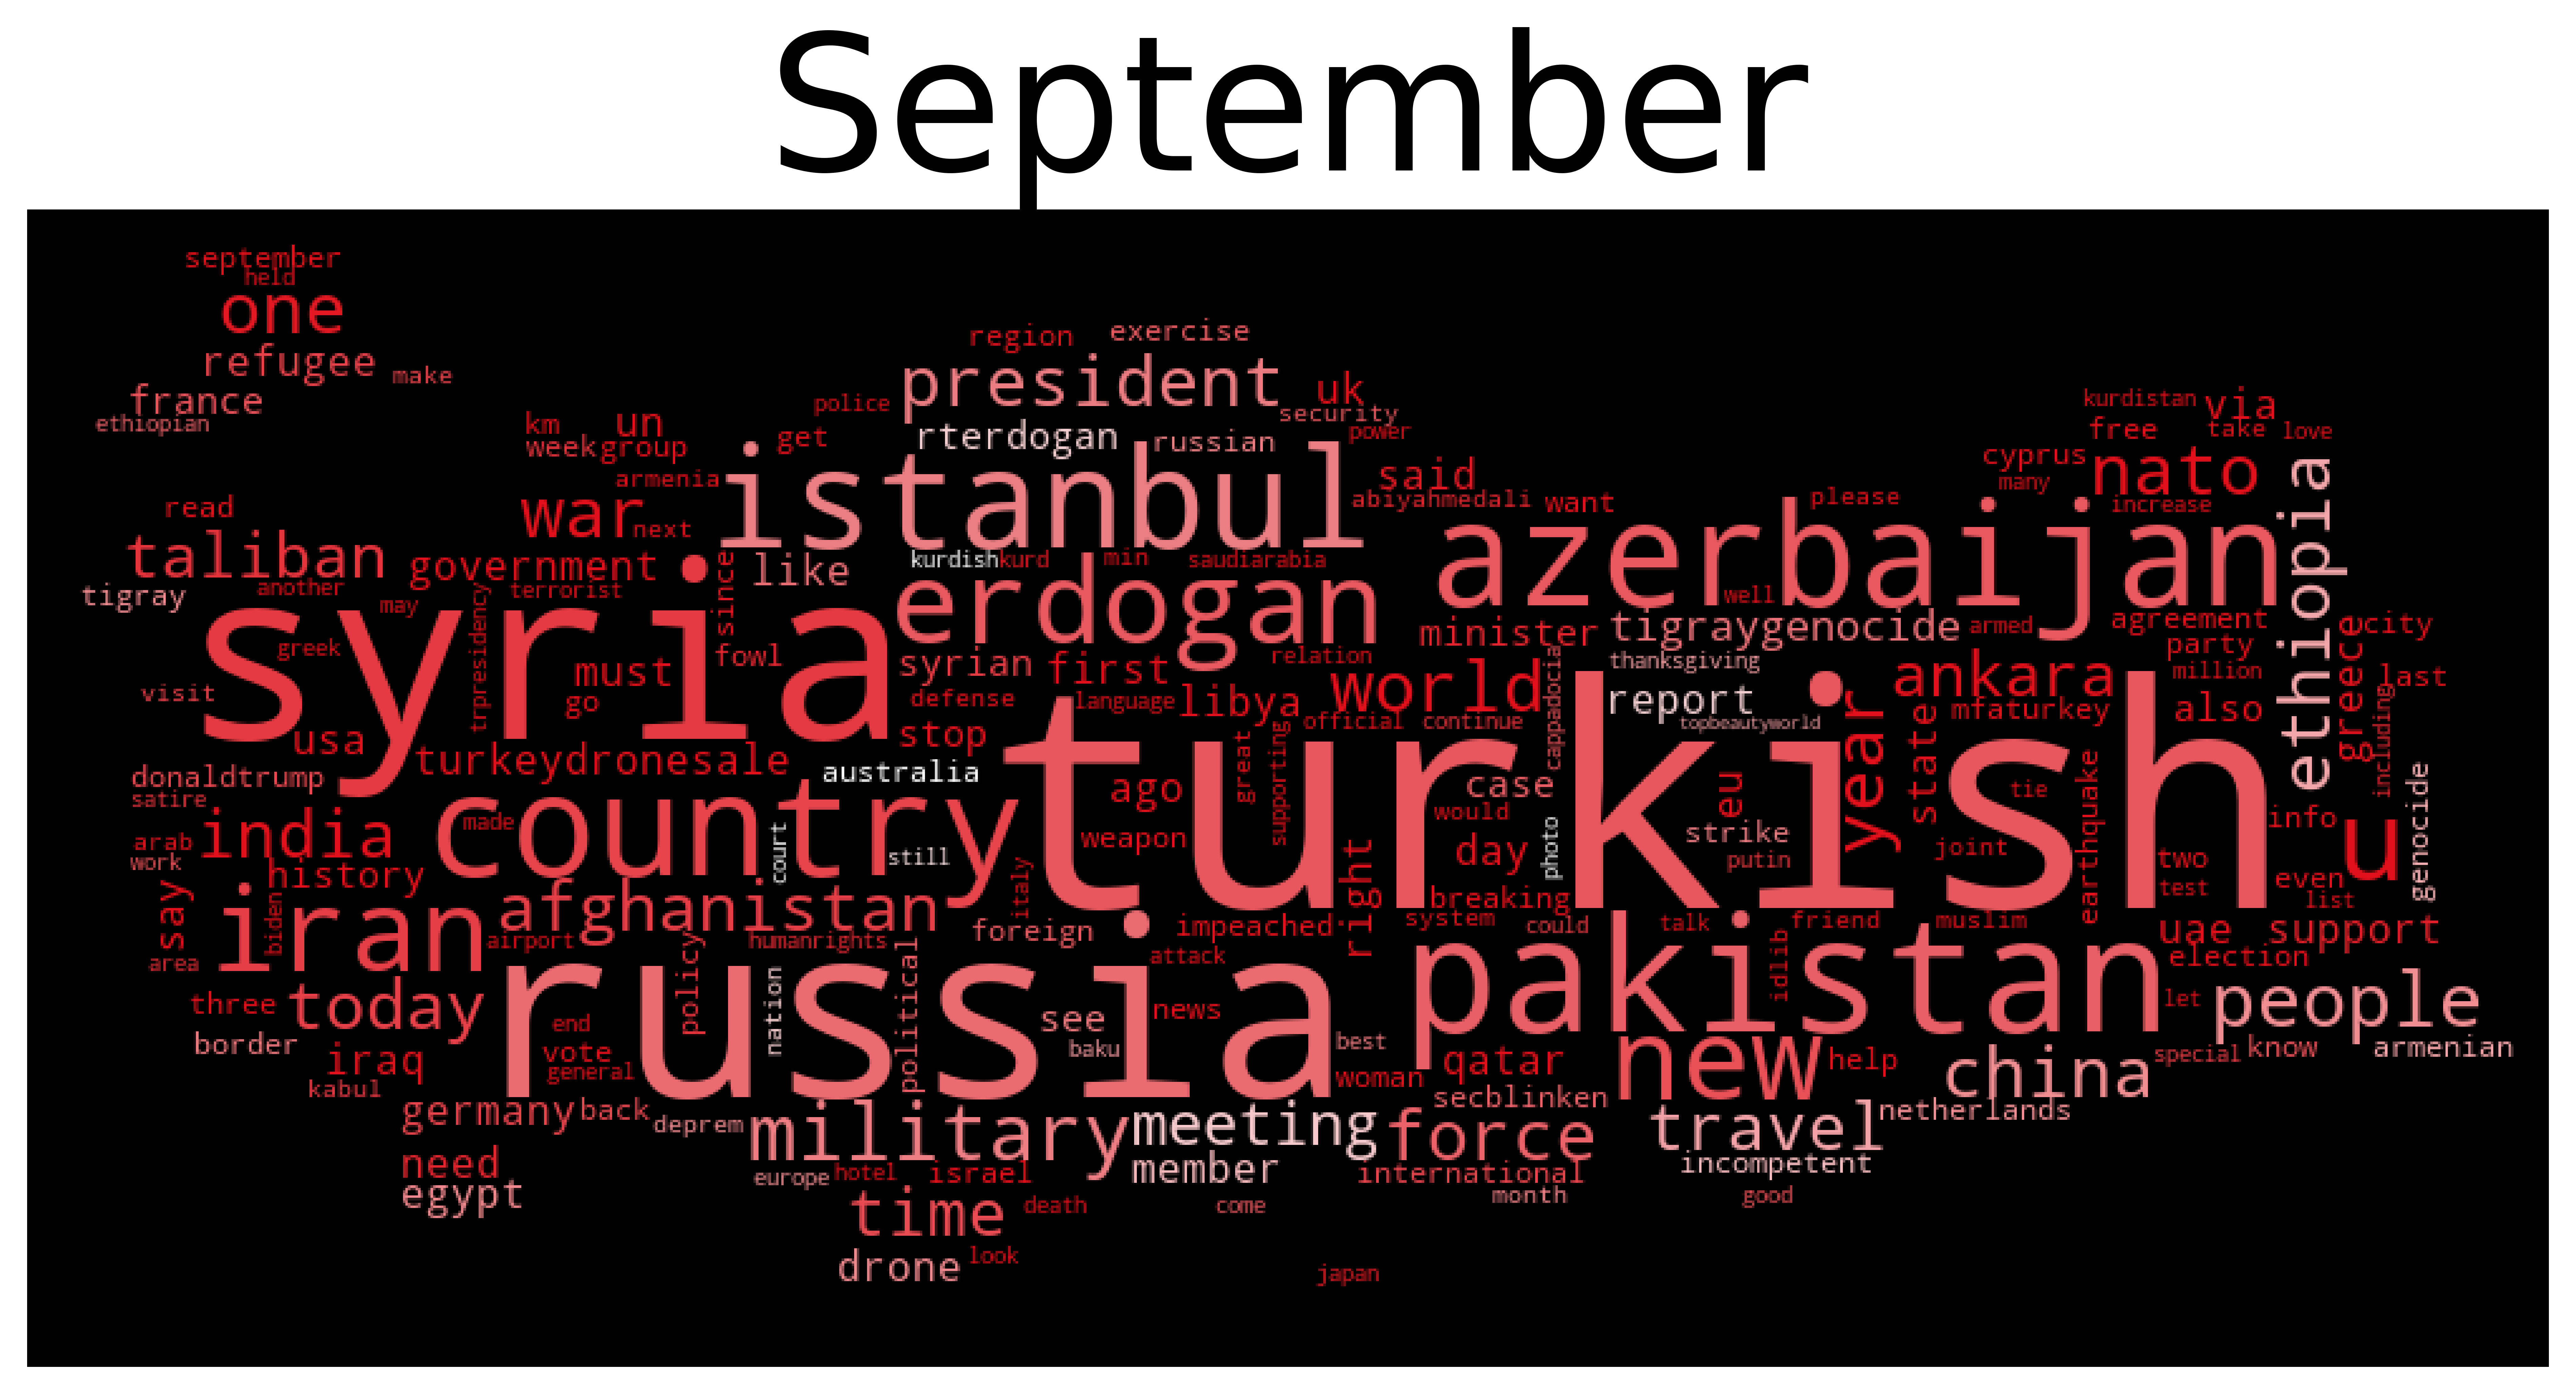

In [5]:
for month in year:
    for country in hashtags:
        print(month, country)
        data = {}
        for file in os.listdir("Tweets/" + month + "/" + country + "/"):
            if file.endswith(".txt"):
                text = []
                with open("Tweets/" + month + "/" + country + "/" + file, "r") as txt_file:
                    for line in txt_file:
                        text.append(line)
                    data[file[:-4]] = text
                    txt_file.close()

        filtered_sentences = []
        result = {}
        result_emotions = {}
        
        start = time.time()
        
        for key, value in data.items():
            score = []
            emotions = []
            for sentence in value:
                word_tokens = word_tokenize(sentence)
                filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
                # usuwanie znakow interpunkcyjnych i wyrazów niebędących w alfabecie łacińskim
                filtered_sentence = [x.lower() for x in filtered_sentence if x.isalpha() and isEnglish(x)]
                ss = sid.polarity_scores(' '.join(filtered_sentence))
                score.append([ss['neg'], ss['neu'], ss['pos']])
                emot = te.get_emotion(' '.join(filtered_sentence))
                emotions.append([emot['Happy'], emot['Angry'], emot['Surprise'], emot['Sad'], emot['Fear']])
                filtered_sentences += filtered_sentence
            result[key] = score
            result_emotions[key] = emotions
        
        end = time.time()
        print(end - start)
            
        with open("Tweets/" + month + "/" + country + "/Results/result.txt", "w") as txt_file:
            for key, value in result.items():
                result[key] = [statistics.mean([i[0] for i in value]), statistics.mean([i[1] for i in value]), statistics.mean([i[2] for i in value])]
                txt_file.write(str(key) + "," + str(result[key][0]) + "," + str(result[key][1]) + "," + str(result[key][2]) + "\n")
        
        with open("Tweets/" + month + "/" + country + "/Results/result_emotions.txt", "w") as txt_file:
            for key, value in result_emotions.items():
                result_emotions[key] = [statistics.mean([i[0] for i in value]), statistics.mean([i[1] for i in value]), statistics.mean([i[2] for i in value]), statistics.mean([i[3] for i in value]), statistics.mean([i[4] for i in value])]
                txt_file.write(str(key) + "," + str(result_emotions[key][0]) + "," + str(result_emotions[key][1]) + "," + str(result_emotions[key][2]) + "," + str(result_emotions[key][3]) + "," + str(result_emotions[key][4]) + "\n")
        
        lemmatizer = WordNetLemmatizer()

        for i in range(len(filtered_sentences)):
            filtered_sentences[i] = lemmatizer.lemmatize(filtered_sentences[i])
        filtered_sentences = dict(Counter(filtered_sentences))
        filtered_sentences = dict(sorted(filtered_sentences.items(), key=lambda item: item[1], reverse=True))
        
        del filtered_sentences[country.lower()]
        
        mask = np.array(Image.open("Masks/" + country + '.png'))
        mask_colors = ImageColorGenerator(mask)
        
        wordcloud = WordCloud(width = mask.shape[1], height = mask.shape[0], mask = mask, color_func=mask_colors).generate_from_frequencies(filtered_sentences)
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['figure.dpi'] = 800
        plt.imshow(wordcloud)
        plt.title(month, size = 50)
        plt.axis('off')
        plt.savefig("Tweets/" + month + "/" + country + "/Results/wordcloud.jpg")
